In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import t
from scipy.stats import stats


In [2]:
df=pd.read_csv('C:/Users/ketak/Desktop/Springboard/capstone ideas/NYSDOH_clean2.csv')

In [3]:

df.dtypes

Unnamed: 0                                 int64
Hospital_Service_Area                     object
Hospital_County                           object
Operating_Certificate_Number             float64
Permanent_Facility_Id                    float64
Facility_Name                             object
Age_Group                                 object
Zip_Code__3_digits                        object
Gender                                    object
Race                                      object
Ethnicity                                 object
Length_of_Stay                           float64
Type_of_Admission                         object
Patient_Disposition                       object
Discharge_Year                             int64
CCS_Diagnosis_Code                         int64
CCS_Diagnosis_Description                 object
CCS_Procedure_Code                         int64
CCS_Procedure_Description                 object
APR_DRG_Code                               int64
APR_DRG_Description 

In [4]:
df.shape

(236147, 36)

In [5]:
df=df.drop('Unnamed: 0',axis=1)

In [6]:
#APR codes:. A higher relative weight is associated with longer length of stay, greater severity of illness, and higher reimbursement. The time of when APR-DRG’s are assigned is unclear. For this reason APR codes will be dropped. More on this in the EDA report
# drop APR codes as APR codes are likely not designaed at the time of admission, and are designated for puporses of reimbursement
df=df.drop(df.iloc[:, 18:26], axis = 1)


In [7]:
df.columns

Index(['Hospital_Service_Area', 'Hospital_County',
       'Operating_Certificate_Number', 'Permanent_Facility_Id',
       'Facility_Name', 'Age_Group', 'Zip_Code__3_digits', 'Gender', 'Race',
       'Ethnicity', 'Length_of_Stay', 'Type_of_Admission',
       'Patient_Disposition', 'Discharge_Year', 'CCS_Diagnosis_Code',
       'CCS_Diagnosis_Description', 'CCS_Procedure_Code',
       'CCS_Procedure_Description', 'Payment_Typology_1', 'Payment_Typology_2',
       'Payment_Typology_3', 'Birth_Weight', 'Abortion_Edit_Indicator',
       'Emergency_Department_Indicator', 'Total_Charges', 'Total_Costs',
       'Ratio_of_Total_Costs_to_Total_Charges'],
      dtype='object')

In [8]:
df.Discharge_Year.unique()

array([2014], dtype=int64)

In [9]:
# drop discahrge_year as it is the same across all rows 2014
df=df.drop('Discharge_Year',axis=1)

In [10]:
df.Abortion_Edit_Indicator.unique()

array(['N'], dtype=object)

In [11]:
# Abortion related records as the values/records for where there were abortions have been deidentified and will therefore this column is dropped
df=df.drop('Abortion_Edit_Indicator',axis=1)

(211945, 25)

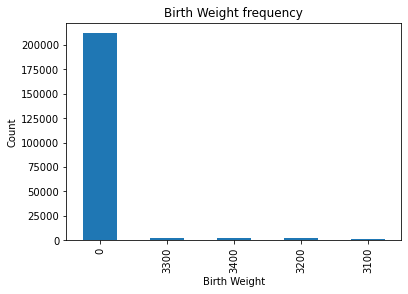

In [13]:
#Birth weight column
(df['Birth_Weight'].value_counts().head(5)).plot(kind='bar')
plt.xlabel('Birth Weight')
plt.ylabel('Count')
plt.title('Birth Weight frequency')
# appears that majority of the hospital admissions do not constitue newborns
df[df['Birth_Weight']==0].shape

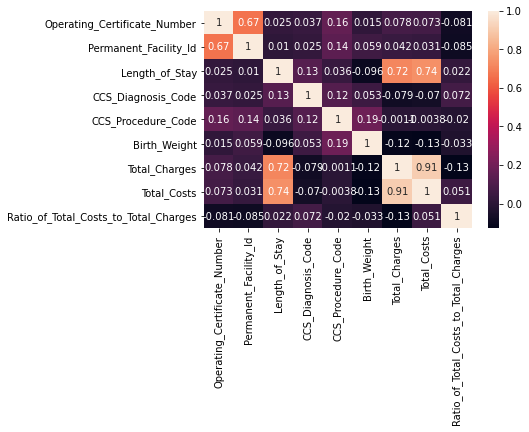

In [13]:
# create a correlation matrix, some of the columns are non ordered data...(operating_certificate_number, permenant_facility_id,diagnosis and procedure codes)
correlation_mat = df.corr()

sns.heatmap(correlation_mat, annot = True)

plt.show()

In [ ]:
#1 The correlation is strongest between total costs and total_charges is strong at .91 which makes sense,
# but this is determined at the end of stay and may not help us predict length of stay,
# so should we take this into consideration?

#2 length of stay and total_charges and total_costs is at .72 and .74 respectively,
# this does make sense as a higher length of stay will correspond to increase costs and charges,
# but again, will the total cost and charge predict length of stay?

#3 lastly operating certficate number and permenant facility id show correlation. 
#The id's are non-ordered , would this correlation then still be relevant? Which other columns to drop?:

#In the context of which variable will predict length of stay,
#I am differentiating variables that are assigned at the time of diagnosis (diagnosis or procedure) 
#versus those that are established at the time of discharge. 
#Total charges, total costs, and total cost to charge ratio are identified after length of stay is complete and thus not useful in predicting length of stay, although the converse will hold true.

In [14]:
# create a subset focusing on relevant columns of interest, drop columns that are not useful for predicting length of stay or those that provide the same information as a column that is already included.
df=df.drop(columns=(['Operating_Certificate_Number','Permanent_Facility_Id','Patient_Disposition','Payment_Typology_2','Payment_Typology_3','Birth_Weight','Total_Charges', 'Total_Costs',
       'Ratio_of_Total_Costs_to_Total_Charges','CCS_Diagnosis_Code','CCS_Procedure_Code']),axis=1)

In [15]:
df.columns


Index(['Hospital_Service_Area', 'Hospital_County', 'Facility_Name',
       'Age_Group', 'Zip_Code__3_digits', 'Gender', 'Race', 'Ethnicity',
       'Length_of_Stay', 'Type_of_Admission', 'CCS_Diagnosis_Description',
       'CCS_Procedure_Description', 'Payment_Typology_1',
       'Emergency_Department_Indicator'],
      dtype='object')

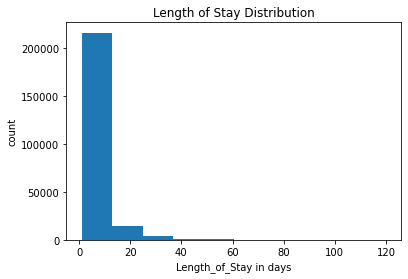

In [14]:
# Target variable is length of stay, univariate data analysis of target

plt.hist(df['Length_of_Stay'])
plt.xlabel('Length_of_Stay in days')
plt.ylabel('count')
plt.title('Length of Stay Distribution')
plt.savefig('length.png')

In [17]:
df['Length_of_Stay'].describe()

count    236147.000000
mean          5.503043
std           8.113239
min           1.000000
25%           2.000000
50%           3.000000
75%           6.000000
max         120.000000
Name: Length_of_Stay, dtype: float64

In [18]:
#the mean length of stay is 5.5 days while the median is 3.00 days. 
#"There are some extreme values such as maximum length of stay which is 120"
# Lets take a look and see how many of the patients have a length of stay above the mean and below the mean

In [15]:
conditions=[(df['Length_of_Stay']<=5.5), (df['Length_of_Stay']>5.5)]
values=['below_mean','above_mean']
df['Length_groups']=np.select(conditions,values)

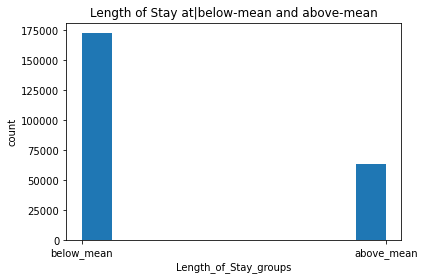

In [18]:
plt.hist(df['Length_groups'])
plt.xlabel('Length_of_Stay_groups')
plt.ylabel('count')
plt.title('Length of Stay at|below-mean and above-mean')
plt.savefig('Length_groups.png')

In [21]:
# A significant percentage (approximately 73%) of the pateint population has length of stay at or  below the mean
numbelow=(df[df['Length_groups']=='below_mean'])
percent_below_mean=((numbelow['Length_groups'].value_counts()*100)/236147)
print('percentage of patients with length of stay below mean is :{}'.format(percent_below_mean))

percentage of patients with length of stay below mean is :below_mean    73.03671
Name: Length_groups, dtype: float64


In [22]:
# lets take a look at 13 features to see if there is any variability in the length of stay amongst these featurs. 
#define function to plot a bar graph for each feature against length of stay and describe 
def plotbar(x):
    dfh=pd.DataFrame(df.groupby(x).Length_of_Stay.mean(),columns=(x,'Length_of_Stay'))
    dfh=dfh.sort_values('Length_of_Stay')
    dfh.describe()
    dfh.head(20).plot(kind='barh') 
    plt.xlabel('length of stay in days')
    plt.ylabel(str(x))
    y=str(x)+' table'
    plt.title(str(y))
    strx=str(x)+'_barh.png'
    plt.savefig(strx)
    dfh.tail(20).plot(kind='barh')
    print(dfh.describe())

       Length_of_Stay
count      258.000000
mean         5.749225
std          3.651308
min          1.000000
25%          3.451301
50%          4.885802
75%          6.817384
max         32.909091


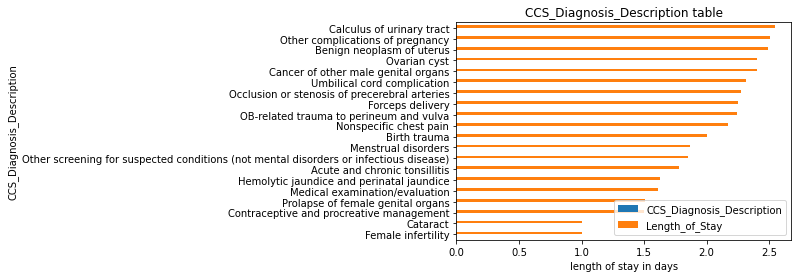

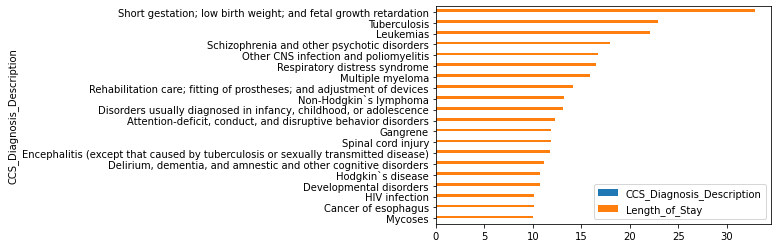

In [23]:
plotbar('CCS_Diagnosis_Description')

In [24]:
# visually we can see that there is a large amount of variablility of out target variable within the 258 CCS diagnosis description groups 

In [38]:
# There are 258 different types of diagnosis categories.Lets take a look at the top 2 most occurring
common_diag=df[df.groupby('CCS_Diagnosis_Description')['CCS_Diagnosis_Description'].transform('size') >8000]
common_diag['CCS_Diagnosis_Description'].unique().shape
common_diag['CCS_Diagnosis_Description'].unique()

array(['Septicemia (except in labor)', 'Liveborn'], dtype=object)

In [39]:
# calculate statistical significance using an independent t-test for the two most commonly occuring diagnosis
liveborn=common_diag[common_diag['CCS_Diagnosis_Description']=='Liveborn']
sep=common_diag[common_diag['CCS_Diagnosis_Description']=='Septicemia (except in labor)']
a=np.array(liveborn['Length_of_Stay'])
b=np.array(sep['Length_of_Stay'])
stats.ttest_ind(a,b)


Ttest_indResult(statistic=-55.91873582528331, pvalue=0.0)

In [27]:
# this shows that for the two most commonly occurring diagnosis, the difference in means is significant

In [40]:
# lets create a subset of our common diagnosis dataframe where the most common 3 insurances were used: cdp
cdp=common_diag.loc[(common_diag['Payment_Typology_1']=='Medicaid')|(common_diag['Payment_Typology_1']=='Medicare')|(common_diag['Payment_Typology_1']=='Medicaid')|(common_diag['Payment_Typology_1']=='Private Health Insurance')]

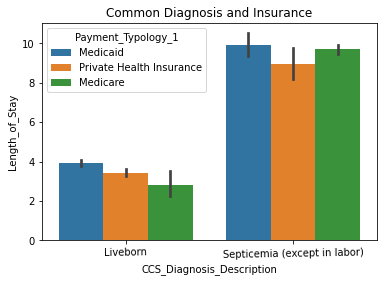

In [41]:
# Let us see the distribution of the most common diagnosis, variability with payment typology for length of stay
ax=sns.barplot(x='CCS_Diagnosis_Description',y='Length_of_Stay',hue='Payment_Typology_1',data=cdp)
plt.setp(ax.get_xticklabels(),rotation=1)
plt.title('Common Diagnosis and Insurance')
plt.savefig('Diag_Insurance_length.png')

       Length_of_Stay
count       57.000000
mean         4.750074
std          0.830934
min          2.809524
25%          4.065789
50%          4.906942
75%          5.389008
max          6.784757


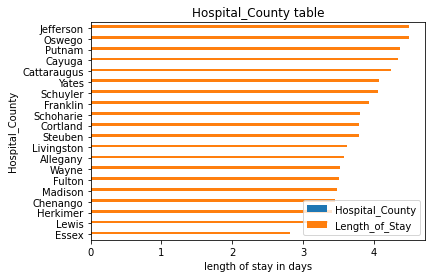

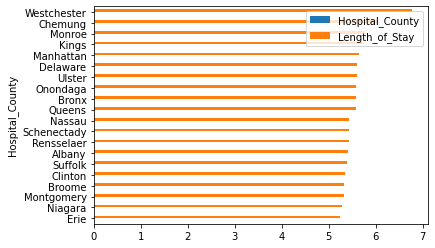

In [27]:
# look at each column of interest in the df_subset
plotbar('Hospital_County')

In [31]:
# there are 50 different counties, lets find the top two most utilsed counties and note if there is a significant difference in mean length of stay
common_county=df[df.groupby('Hospital_County')['Length_of_Stay'].transform('size') >25000]
common_county['Hospital_County'].unique().shape
common_county['Hospital_County'].unique()


array(['Kings', 'Manhattan'], dtype=object)

In [32]:
# calculate statistical significance using an independent t-test for the two most commonly used counties
Kings=common_county[common_county['Hospital_County']=='Kings']
Man=common_county[common_county['Hospital_County']=='Manhattan']
a=np.array(Kings['Length_of_Stay'])
b=np.array(Man['Length_of_Stay'])
stats.ttest_ind(a,b)


Ttest_indResult(statistic=1.5578854587248698, pvalue=0.11926512838219983)

In [33]:
# So the difference of means for the top 2 utilsed counties is not as significant. 
# But, based on the graph, the lowest mean length of stay is in Essex county at liitle more than 2.5 days and the most mean length of stay is at Westchester county more than 6.5 days

       Length_of_Stay
count        6.000000
mean         5.273317
std          0.993654
min          3.703994
25%          4.777413
50%          5.439003
75%          6.054103
max          6.241883


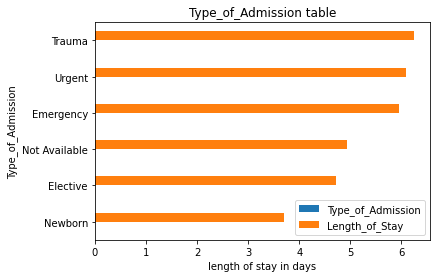

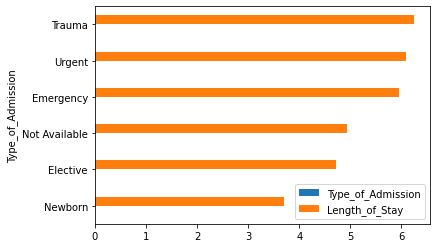

In [28]:
#It appears that people admitted for trauma have a higher mean length of stay than all the means of all the other categories

plotbar('Type_of_Admission')

       Length_of_Stay
count        8.000000
mean         5.380569
std          0.279931
min          5.068794
25%          5.162208
50%          5.326472
75%          5.558734
max          5.869101


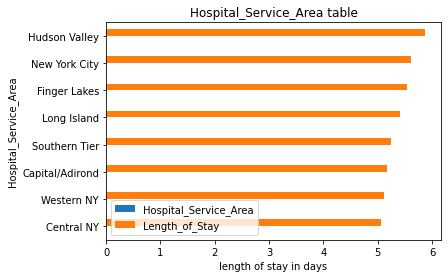

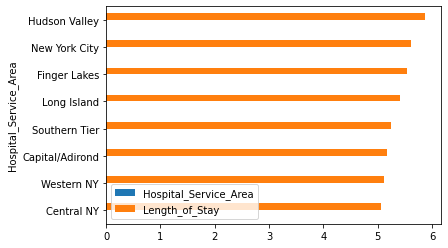

In [29]:
# it appears that the range of mean length of stay is between 5 and 6 days for Hopsital Service areas
plotbar('Hospital_Service_Area')

       Length_of_Stay
count      228.000000
mean         6.178128
std          5.008153
min          2.000000
25%          4.228729
50%          4.973802
75%          6.186719
max         54.916667


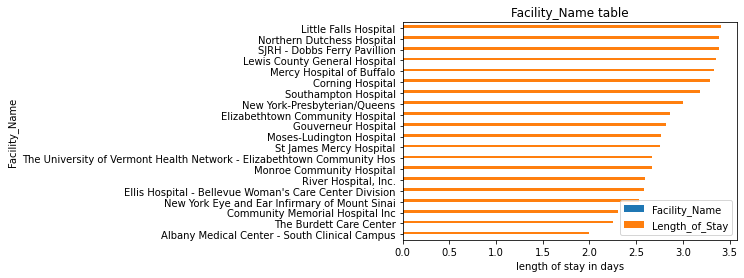

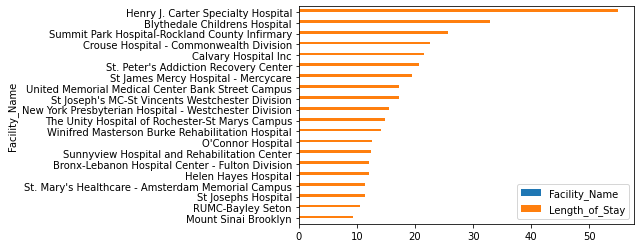

In [30]:
# There appears to be quite a large variablity in mean length of stay dpeending on the facility, 
#this is not surprisng as facilities may be be designated differently as trauma centers, rehabilitation hospitals etc
plotbar('Facility_Name')

       Length_of_Stay
count        5.000000
mean         5.234384
std          1.039617
min          3.992414
25%          4.607939
50%          4.983031
75%          6.096282
max          6.492256


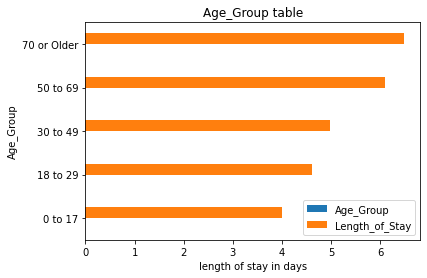

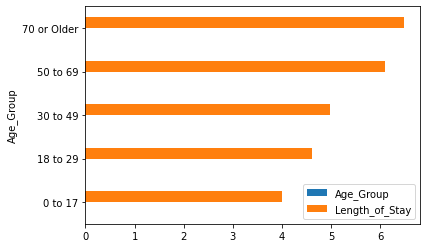

In [31]:
plotbar('Age_Group')

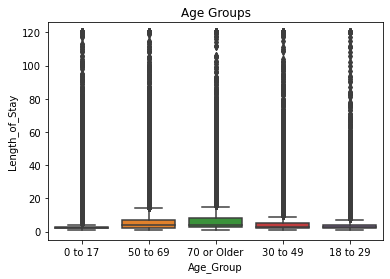

In [54]:
ax=sns.boxplot(x='Age_Group',y='Length_of_Stay',data=df)
ax.set_title('Age Groups')
plt.savefig('AgeGenderbox.png')

In [55]:
    # The 70 or older group seems to have a slightly higher mean length of stay compared to the other groups, 
# we will check for statistical signififcance for difference of means amongst different age groups using a one way ANOVA.


In [57]:
a=df[df['Age_Group']=='0 to 17']['Length_of_Stay']
b=df[df['Age_Group']=='18 to 29']['Length_of_Stay']
c=df[df['Age_Group']=='30 to 49']['Length_of_Stay']
d=df[df['Age_Group']=='50 to 69']['Length_of_Stay']
e=df[df['Age_Group']=='70 or Older']['Length_of_Stay']
stats.f_oneway(a,b,c,d,e)

F_onewayResult(statistic=769.4111187233224, pvalue=0.0)

       Length_of_Stay
count       51.000000
mean         5.444038
std          0.490541
min          4.688165
25%          5.122078
50%          5.347367
75%          5.724928
max          7.015134


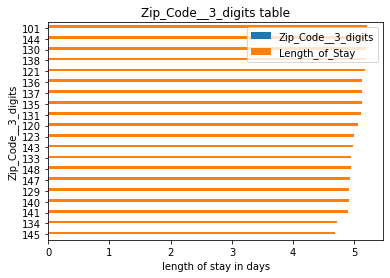

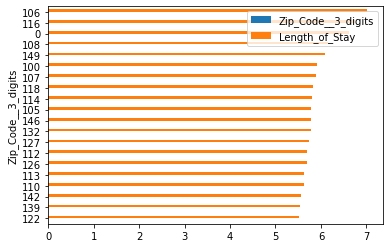

In [32]:
# it appears that there is some variability in mean length of stay by zipcode
plotbar('Zip_Code__3_digits')

       Length_of_Stay
count        3.000000
mean         4.701916
std          1.533513
min          3.000000
25%          4.064733
50%          5.129465
75%          5.552873
max          5.976281


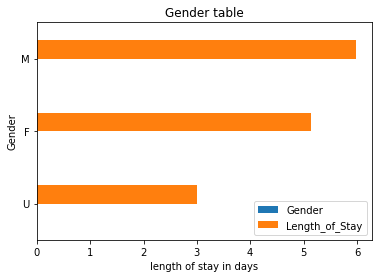

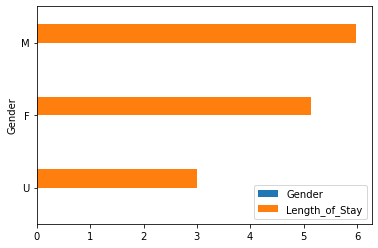

In [33]:
plotbar('Gender')

In [40]:
# let us consider the male and female gender and compare lengths of stay for those groups
male=df[df['Gender']=='M']
a=male['Length_of_Stay']
female=df[df['Gender']=='F']
b=female['Length_of_Stay']
stats.ttest_ind(a,b)

Ttest_indResult(statistic=25.217966264380546, pvalue=3.9072007331910153e-140)

       Length_of_Stay
count        4.000000
mean         5.610376
std          0.410515
min          5.189697
25%          5.359306
50%          5.554267
75%          5.805337
max          6.143272


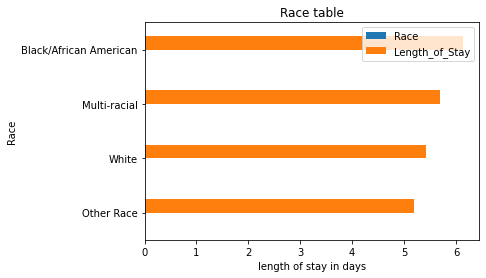

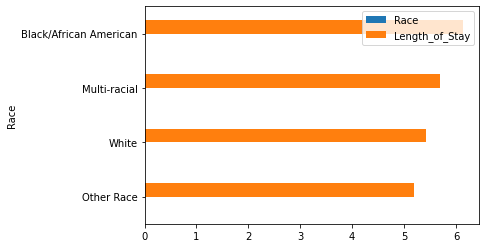

In [34]:
plotbar('Race')

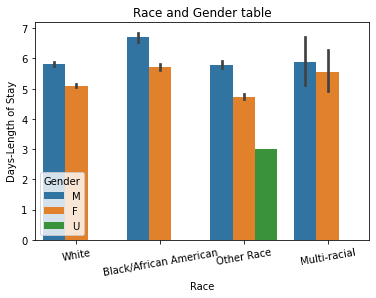

In [26]:
ax=sns.barplot(x='Race',y='Length_of_Stay', hue='Gender', data=df)
plt.setp(ax.get_xticklabels(), rotation=10)
plt.ylabel('Days-Length of Stay')
plt.title('Race and Gender table')
plt.savefig('RaceGender.png')

In [43]:
# Run a one way ANOVA to check for statistical significance
AA=df[df['Race']=='Black/African American']['Length_of_Stay']
MR=df[df['Race']=='Multi-racial']['Length_of_Stay']
WH=df[df['Race']=='White']['Length_of_Stay']
OR=df[df['Race']=='Other Race']['Length_of_Stay']
stats.f_oneway(AA,MR,WH,OR)

F_onewayResult(statistic=126.83538781031723, pvalue=4.300744788963657e-82)

       Length_of_Stay
count        4.000000
mean         5.145173
std          0.517607
min          4.471805
25%          4.872897
50%          5.265194
75%          5.537470
max          5.578497


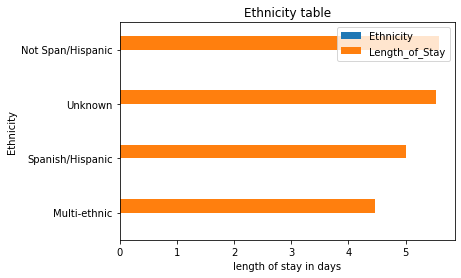

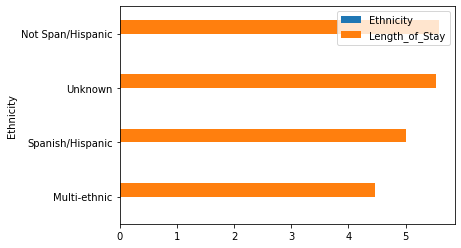

In [35]:
# in this feature the primary groups are Spanish/Hispanic and the other group categories are not as distinct, 
#this column due to lack of useful seperation of groups may be dropeed
plotbar('Ethnicity')

In [45]:
df=df.drop('Ethnicity',axis=1)

       Length_of_Stay
count      227.000000
mean         6.793957
std          4.900731
min          1.543478
25%          4.041769
50%          5.726257
75%          8.191443
max         41.072193


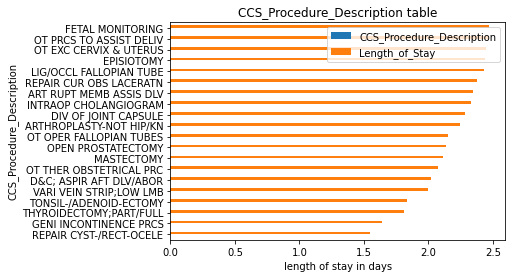

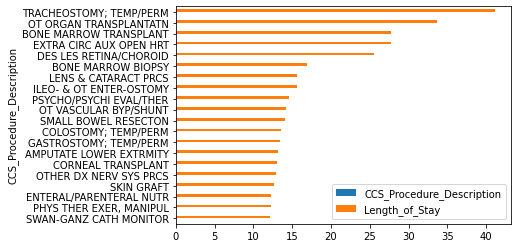

In [36]:
#there are 227 different types of CCS procedure groups with variability between the groups
plotbar('CCS_Procedure_Description')

In [47]:
common_proc=df[df.groupby('CCS_Procedure_Description')['CCS_Procedure_Description'].transform('size') > 8000]
common_proc['CCS_Procedure_Description'].unique().shape
common_proc['CCS_Procedure_Description'].unique()

array(['NO PROC', 'PROPHYLACTIC VAC/INOCUL', 'OTHER THERAPEUTIC PRCS'],
      dtype=object)

In [48]:
vac=df[df['CCS_Procedure_Description']=='PROPHYLACTIC VAC/INOCUL']
a=vac['Length_of_Stay']
ther=df[df['CCS_Procedure_Description']=='OTHER THERAPEUTIC PRCS']
b=ther['Length_of_Stay']
stats.ttest_ind(a,b)

Ttest_indResult(statistic=-30.831807716363706, pvalue=7.878978220051006e-205)

In [49]:
# lets look at the top 5 most commonly utilsed CCS procedure descriptions 
common_proc=df[df.groupby('CCS_Procedure_Description')['CCS_Procedure_Description'].transform('size') > 7200]
common_proc['CCS_Procedure_Description'].unique().shape
common_proc['CCS_Procedure_Description'].unique()

array(['NO PROC', 'OT PRCS TO ASSIST DELIV', 'CESAREAN SECTION',
       'PROPHYLACTIC VAC/INOCUL', 'OTHER THERAPEUTIC PRCS'], dtype=object)

In [50]:
#df.to_csv('NYSDOH_clean3.csv')

In [58]:
df.dtypes

Hospital_Service_Area              object
Hospital_County                    object
Facility_Name                      object
Age_Group                          object
Zip_Code__3_digits                 object
Gender                             object
Race                               object
Length_of_Stay                    float64
Type_of_Admission                  object
CCS_Diagnosis_Description          object
CCS_Procedure_Description          object
Payment_Typology_1                 object
Emergency_Department_Indicator     object
Length_groups                      object
dtype: object

In [70]:
df.columns

Index(['Hospital_Service_Area', 'Hospital_County', 'Facility_Name',
       'Age_Group', 'Zip_Code__3_digits', 'Gender', 'Race', 'Length_of_Stay',
       'Type_of_Admission', 'CCS_Diagnosis_Description',
       'CCS_Procedure_Description', 'Payment_Typology_1',
       'Emergency_Department_Indicator', 'Length_groups'],
      dtype='object')

In [79]:
#Convert categorical data to numeric using get_dummies to prepare for further processing
#X=df.drop(['Length_of_Stay','Length_groups'],axis=1)

In [81]:
#X=pd.get_dummies(data=X,drop_first=True)

In [82]:
#X.shape

(236147, 847)

In [84]:
#df.to_csv('X.csv')

In [85]:
#df.to_csv('y.csv')

In [83]:
#y=df['Length_of_Stay']

In [73]:
#df.to_csv('NYSDOH_df1.csv')